### Build env for this notebook (temp. fix):

```
conda env create -n dnn_cpu python=3.12 numpy pandas scikit-learn tensorflow-cpu
conda activate dnn_cpu
```

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
# from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer
np.random.seed(0)
tf.random.set_seed(0)

In [159]:
import pickle
with open("../data/tmp_data/svc_at_sugaramino_ml_data.pickle", "rb") as handle:
    ml_datasets = pickle.load(handle)
with open("../data/tmp_data/svc_at_sugaramino_outlier_removal_ml_data.pickle", "rb") as handle:
    ml_datasets_filtered = pickle.load(handle)

In [160]:
ml_datasets[12]

Name: PROSTT5_3DI, Features: 1024, Samples: 54, Classes: [0 1], Labels: ['amino acid transmembrane transporter activity'
 'sugar transmembrane transporter activity'])

In [ ]:
from tensorflow import keras

# TODO test other model

# model = Sequential([
#     Dense(512, activation='relu', input_shape=(1024,)),
#     BatchNormalization(),
#     Dropout(0.3),

#     Dense(128, activation='relu'),
#     Dropout(0.3),

#     Dense(1, activation='sigmoid') 
# ])

# model.compile(
#     optimizer=Adam(learning_rate=1e-3),
#     loss=BinaryCrossentropy(),
#     metrics=[BinaryAccuracy()]
# )

def create_model(input_shape):
    # TODO possibly more layers, try without dropout
    model = keras.Sequential(
        [
            keras.layers.Input(shape=(input_shape,)),
            keras.layers.Dense(512, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(
        optimizer="adam",  
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.F1Score(average="macro",name="F1_macro"),
            keras.metrics.TruePositives(name="TP"),
            keras.metrics.TrueNegatives(name="TN"),
            keras.metrics.FalsePositives(name="FP"),
            keras.metrics.FalseNegatives(name="FN"),
        ],
    ) 

    # TODO try BatchNormalization
    # TODO class weights
    # TODO early stopping?
    # TODO macro
    return model

In [ ]:
# TODO different model sizes depending on input size. Build model up from adding things
# 400	 256 - 128 - 64 
# 1024 512 - 256 - 128 
# 2020 1024 - 512 - 256 

In [197]:
def nested_crossval(
    ml_dataset, model_func, scores_dict, splits=5, repeats=5, epochs=100, batch_size=8
):
    print(f"=== {ml_dataset.name} ===")
    preprocess = make_pipeline(VarianceThreshold(0.0), StandardScaler())

    X, y = ml_dataset.X, ml_dataset.y

    train_scores = list()
    test_scores = list()
    fold_count = 1
    for train_idx_outer, val_idx_outer in RepeatedStratifiedKFold(
        n_splits=splits, n_repeats=repeats, random_state=0
    ).split(X, y):
        print(f"Fold {fold_count} out of {splits*repeats}")
        fold_count += 1

        X_train, X_test = X[train_idx_outer], X[val_idx_outer]
        y_train, y_test = y[train_idx_outer], y[val_idx_outer]

        X_train = preprocess.fit_transform(X_train, y_train)
        X_test = preprocess.transform(X_test)

        model = model_func(X_train.shape[1])
        # early_stop = keras.callbacks.EarlyStopping(
        #     monitor='loss',
        #     patience=5,
        #     restore_best_weights=True
        # )
        training_data = model.fit(
            X_train,
            y_train.reshape(-1, 1),
            epochs=epochs,
            batch_size=batch_size,
            # callbacks=[early_stop],
            verbose=0,
        )
        y_prob = model.predict(X_test)
        y_pred = (y_prob > 0.5).astype(int).flatten()
        # TODO mis-classified samples: stats!

        for score_name, score_func in scores_dict.items():
            test_scores.append((ml_dataset.name,score_name, score_func(y_test, y_pred)))
            print(score_name, score_func(y_test, y_pred))

        res = model.evaluate(X_test, y_test.reshape(-1, 1))
        print(res)
    df_scores = pd.DataFrame(test_scores, columns=["feature","score", "value"])

    return df_scores

In [198]:
for pos, ml_dataset in enumerate(ml_datasets):
    print(pos, ml_dataset.name, len(ml_dataset.feature_names))

ml_datasets = [
    ml_dataset for ml_dataset in ml_datasets if len(ml_dataset.feature_names) >= 400
]

0 DUMMY 1024
1 PAAC 400
2 AA_KMER3 8000
3 3Di_KMER2 400
4 3Di_KMER3 8000
5 COMB_KMER2 800
6 COMB_KMER3 16000
7 PROTT5_AA 1024
8 PROSTT5_AA 1024
9 PROSTT5_3DI 1024
10 PSSM_50_1 400
11 PSSM_50_3 400
12 PSSM_90_1 400
13 PSSM_90_3 400
14 PSSM_META 1600
15 META 2020
16 META_STD 2020


In [199]:
len(ml_datasets[1].feature_names)

400

In [ ]:
scoring_outer = {
    "Balanced Accuracy": balanced_accuracy_score,
    "F1 Macro": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, average="macro"
    ),
    "F1 Amino Acid": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=0
    ),
    "F1 Sugar": lambda y_test, y_pred: f1_score(
        y_true=y_test, y_pred=y_pred, pos_label=1
    ),
}


# TODO batch size: smaller batch means better generalization. try 16–64
# TODO epochs. Early Stopping
# TODO try create_model function where differently-sized dnns are created, compare. Also maybe different values for dropout (0.3, 0.7)
results = [
    nested_crossval(
        ml_dataset=ml_dataset,
        model_func=lambda n_features: create_model(n_features),
        scores_dict=scoring_outer,
        splits=5,
        repeats=5,
        epochs=50,
        batch_size=16,
    )
    for ml_dataset in ml_datasets
]

=== DUMMY ===
Fold 1 out of 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Balanced Accuracy 0.7333333333333334
F1 Macro 0.7272727272727273
F1 Amino Acid 0.7272727272727273
F1 Sugar 0.7272727272727273
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - f1_score: 0.7059 - false_negatives_533: 2.0000 - false_positives_533: 1.0000 - loss: 0.7161 - true_negatives_533: 4.0000 - true_positives_533: 4.0000
[0.7161173224449158, 0.7058823108673096, 2.0, 1.0, 4.0, 4.0]
Fold 2 out of 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Balanced Accuracy 0.5333333333333333
F1 Macro 0.5299145299145299
F1 Amino Acid 0.4444444444444444
F1 Sugar 0.6153846153846154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - f1_score: 0.7059 - false_negatives_534: 2.0000 - false_positives_534: 3.0000 - loss: 0.9982 - true_negatives_534: 2.0000 - true_positives_534: 4.0000
[0.9982065558433533, 0.7058823108673096, 2.0, 3.0, 4.0, 2.0]
Fold 3 out of 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Balanced Accuracy 0.4166666666666667
F1 Macro 0.3125
F1 Amino Aci

(0.0, 1.05)

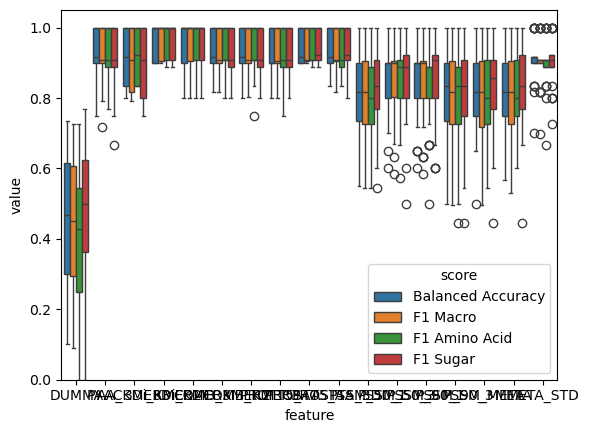

In [202]:
import seaborn as sns

df_results_all = pd.concat(results)
df_results_all_f1 = df_results_all[df_results_all.score.isin(["F1 Amino Acid","F1 Sugar"])]

ax = sns.boxplot(df_results_all, x="feature", y="value", hue="score")
ax.set_ylim(0,1.05)